# 1. Introduction
This notebook will be used to test out different segmentation algorithms on the TEM dataset and make observations as to their structure and efficacy. 

# 2. Clustering
This first algorithm to be assessed is one based on k-means clustering. First we import the relevant libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2 as cv

from pathlib import Path
from sklearn.cluster import KMeans
from scipy.ndimage import label

Load random image from one of the data subdirectories. Subdir can be either 'Fibres', 'Films_Coated_Surface', 'Nanowires', 'Particles', 'Powder'.

In [2]:
subdir = 'Particles'
p =  Path(f'../data/{subdir}').glob('**/*')
file_list = [x for x in p if x.is_file()]
file = np.random.choice(file_list)

Alternatively, uncomment below cell to load a specific image. The file currently specified has been picked because I think it is a good example of an image where a robust segmentation algorithm would be useful.

In [3]:
file = '../data/Easy_to_segment/m.jpg'

Print out the filename and load the image

../data/Easy_to_segment/m.jpg


(-0.5, 1023.5, 767.5, -0.5)

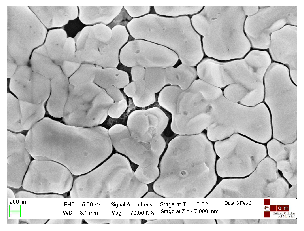

In [4]:
print(file)

img = plt.imread(file)
plt.imshow(img)
plt.axis('off')

Convert image to 2-dimensional array with shape = (length * width, channels) and apply k-means algorithm to obtain clusters.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


running time = 26.549943208694458


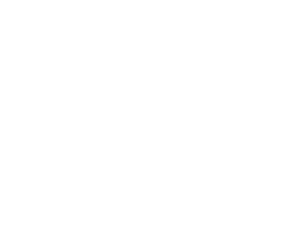

In [12]:
start = time.time()

img_n = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

kmeans = KMeans(n_clusters = 5, random_state = 0).fit(img_n)
img2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_img = img2show.reshape(img.shape[0], img.shape[1], img.shape[2])
plt.imshow(cluster_img)
plt.axis('off')

print(f'running time = {time.time() - start}')

## Observations
Using the kmeans clustering algorithm on an "easy to segment" image works better with larger n_clusters. However, even with 100 clusters which takes approx. 6 min, the result is not very good.

# 3. Watershed Algorithm
Next, let's try the watershed algorithm which views a grayscale image as a topographical surface that needs to be "filled" with water. In order to successfully implement the algorithm, a few preprocessing steps must be employed first.

## Otsu's Binarization
First, the image needs to be converted to grayscale and an otsu binarization employed.

(-0.5, 1023.5, 767.5, -0.5)

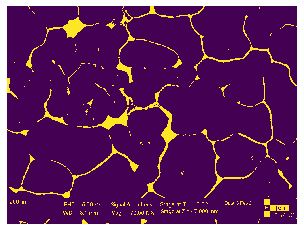

In [6]:
gray =  cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh =  cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)  # Otsu binarization
plt.imshow(thresh)
plt.axis('off')

## Finding the border
Next we specify the regions which we are unsure whether it is the foreground or the background. This is obtained by subtracting the sure_fg area from the sure_bg area.

(-0.5, 1023.5, 767.5, -0.5)

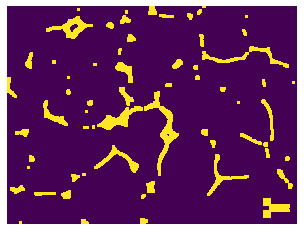

In [7]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations = 2)

# sure background area
sure_bg = cv.dilate(opening, kernel, iterations = 3)

# sure foreground area
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

plt.imshow(unknown)
plt.axis('off')

## Create Marker
Finally, we create a marker and label the regions inside it.

<class 'numpy.ndarray'>


(-0.5, 1023.5, 767.5, -0.5)

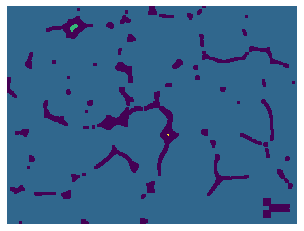

In [8]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
markers = markers + 1
print (type(markers))
# Mark unknown region with zero
markers[unknown == 255] = 0
plt.imshow(markers)
plt.axis('off')

Finally, apply the watershed algorithm to "fill" in the topographical image keeping in mind the unknown markers we previously labelled.

(-0.5, 1023.5, 767.5, -0.5)

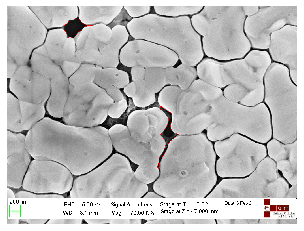

In [9]:
markers = cv.watershed(img, markers)
imgcopy = img.copy()
imgcopy[markers == -1] = [255, 0, 0]
plt.imshow(imgcopy)
plt.axis('off')

## Observations
Since the algorithm is based almost exclusively on intensity values, it is difficult for it to segment images that doesn't have clearly distinct regions of different intensity. As well, it doesn't really perform instance segmentation which is the main part of the proposed project. Finally, it requires a lot of preprocessing that requires the researcher to play around with lots of different values before producing an image fit to even have the algorithm applied

# 4. Mask R-CNN
One of the preferred deep learning methods for image/instance segmentation. As this requires downloading already pretrained weights, cloning another repo into this one, and using a GPU, I feel it is best to take notes on how the method works. The reference for these notes can be found here: https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/?utm_source=blog&utm_medium=introduction-image-segmentation-techniques-python

## Clone repository and Install Dependencies
The first step is to clone the following repository: https://github.com/matterport/Mask_RCNN/releases

Then the following libraries are needed:
- numpy
- scipy
- Pillow
- cython
- matplotlib
- scikit-image
- tensorflow
- keras
- opencv - python
- h5py
- imgaug
- IPython

## Download pre-trained weights
Next the pre-trained weights can be downloaded from here: https://github.com/matterport/Mask_RCNN/releases under mask_rcnn_balloon.h5. The file is 244 MB in size.

## Inference Class
After importing the relevant libraries and defining the path for the pretrained weights/images, the next step is to create an inference class to infer the Mask R-CNN model. This class inherits from the coco.CoCoConfig class. From the summary, we see that the backbone is a resnet101 and the mask shape that will be returned is 28X28. There is also a total of 81 classes (including the background). The inputs are 1024X1024X3 with 50 validation steps and one GPU.


## Loading Weights
The next step is to load the pretrained weights. A model object is called in inference mode by calling mrcnn.model.MaskRCNN(mode = 'inference', model_dir = 'mask_rcnn_coco.hy', config = config). The pre-trained weights are then loaded using model.load_weights('mask_rcnn_coco.h5', by_name = True). After that, just define the class_names in a separate list.

## Making Predictions
When making predictions on an image (using model.detect), verbose will display information on the following hyperparameters: image, molded_images, image_metas, and anchors. For each of these, the shape, min, max, and dtype is reported. The first element of the result can be turned into a mask which gives us a t3d array of 0s and 1s with the 3rd dimension representing the number of objects segmented by the model. to get each segment from the image, use a for loop and multiply each mask with the original image.

# 5. Revisiting the Watershed Algorithm
The following show some other preprocessing steps that use the watershed algorithm as the final segmentation algorithm. The example for this one can be found here: https://stackoverflow.com/questions/11294859/how-to-define-the-markers-for-watershed-in-opencv/14617359#14617359.


## Preprocessing

In [10]:
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_OTSU)
thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, np.ones((3, 3), dtype = int))

## Segment

(-0.5, 1023.5, 767.5, -0.5)

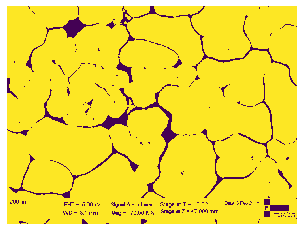

In [11]:
border = cv.dilate(thresh, None, iterations = 5)
border = border - cv.erode(border, None)

dt = cv.distanceTransform(thresh, 2, 3)
dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
ret, dt = cv.threshold(dt, 0, 255, cv.THRESH_BINARY)
lbl, ncc = label(dt)
lbl = lbl * (255 / (ncc + 1))

lbl[border == 255] = 255
lbl = lbl.astype(np.int32)
cv.watershed(img, lbl)

lbl[lbl == -1] = 0
lbl = lbl.astype(np.uint8)
lbl = 255 - lbl

plt.imshow(dt)
plt.axis('off')

# 6. E-Net Architecture
Another deep learning based algorithm using openCV is the E-Net. It's supposed to be very fast and the efficient with the model only being 3.7MB in size. The tutorial I am following can be found here: https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/ and it uses a cityscape image dataset for training. This model has 20 classes.

## Deep Learning
After loading the image and classes, the deep learning architecture is applied the following way. First the model is loaded using the cv.dnn.readNet() function. Then a "blob" is constructed using openCV's cv.dnn.blobFromImage() function. Below is more information on how blobFromImage() works.

## blobFromImage()
blobFromImage() comes from openCV's dnn (deep neural network) module. The function is used for facilitating preprocessing for deep learning classification. The function performs: Mean subtraction, scaling, and optional channel swapping. This is essentially feature normalization on the RGB colour channels of the image.

## Deep Learning Cont.
The resulting blob is then used as the input to a forward pass through the neural network. Finally, argmax is used to find the class label with the largest probability for each pixel. This creates a classmap which can then be turned into a mask or the raw result can be used to perform calculations.

# 7. Conclusion
There are many methods of segmenting using openCV. In terms of non-deep learning methods, the standard one to use would be the watershed algorithm. This algorithm works fairly well on the images but requires preprocessing in order to obtain good results. Moving forward, the watershed algorithm may be the best option to label the images.

In terms of deep learning based methods, one can use Mask R-CNN or E-Net. Both require a GPU and there are pre-trained models on other datasets that may make it useful for transfer learning. However, it would most likely be best to use an architecture that has been trained on optical microscopy images as those are closer to the types of images we are looking at.